<a href="https://colab.research.google.com/github/ruchi571993/Emotion-Recognition-using-Attention-based-LSTM/blob/master/Emotion_Recognition_Attention_based_LSTM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#pip install tensorflow==1.14

In [0]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.Session(config=config)
set_session(sess)

In [0]:
import tensorflow as tf
from keras import Model, Input
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, CuDNNLSTM, Dropout, TimeDistributed, Reshape, Activation, Dot
from keras.layers.wrappers import Bidirectional
from keras.utils import to_categorical
import numpy as np 
import pandas as pd
import random
import matplotlib.pyplot as plt; plt.rcdefaults()
from IPython.core.display import display, HTML
%matplotlib inline

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded_train = drive.CreateFile({'id':"1Wr2IChJjAuaPKMchF6a3mrqMEim-zMNY"})   # 
downloaded_train.GetContentFile('emotiondata.csv')

In [0]:
import pandas as pd
df = pd.read_csv('emotiondata.csv')
df=df.iloc[:10000,:]

In [0]:
df.head()

,Unnamed: 0,text,emotions
0,27383,i feel awful about it too because it s my job ...,sadness
1,110083,im alone i feel awful,sadness
2,140764,ive probably mentioned this before but i reall...,joy
3,100071,i was feeling a little low few days back,sadness
4,2837,i beleive that i am much more sensitive to oth...,love


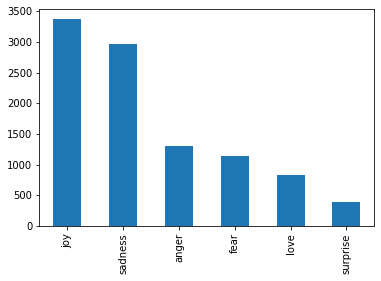

In [0]:
df.emotions.value_counts().plot.bar()

In [0]:
text_tokens = [text.split(" ") for text in df["text"].values.tolist()]
text = df["text"].values.tolist()
labels = df["emotions"].values.tolist()

# Tokenizer

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

In [0]:
word2id = tokenizer.word_index
vocab_size = len(word2id) + 1

# Generating data

In [0]:
embedding_dim = 100
max_len = 150

In [0]:
X = [[word2id[word] for word in sent] for sent in text_tokens]
print(X[0])

[1, 2, 412, 25, 12, 89, 36, 12, 88, 10, 316, 4, 52, 82, 11, 6, 1045, 4, 2549, 3, 12, 33, 238, 39, 530, 140]


In [0]:
pad = 'post'
X_pad = pad_sequences(X, maxlen=max_len, padding=pad, truncating=pad)

In [0]:
print(X_pad[0])

[   1    2  412   25   12   89   36   12   88   10  316    4   52   82
   11    6 1045    4 2549    3   12   33  238   39  530  140    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


In [0]:
label2id = {l: i for i, l in enumerate(set(labels))}
id2label = {v: k for k, v in label2id.items()}
id2label

{0: 'sadness', 1: 'love', 2: 'surprise', 3: 'fear', 4: 'anger', 5: 'joy'}

In [0]:
y = [label2id[label] for label in labels]

In [0]:
y = to_categorical(y, num_classes=len(label2id), dtype='float32')

In [0]:
print("X (shape): {}".format(X_pad.shape))
print("y (shape): {}".format(y.shape))

X (shape): (10000, 150)
y (shape): (10000, 6)


# Create model

In [0]:
seq_input = Input(shape=(max_len,), dtype='int32')

In [0]:
embedded = Embedding(vocab_size,
                     embedding_dim,
                     input_length=max_len)(seq_input)

In [0]:
embedded = Dropout(0.2)(embedded)

In [0]:
from keras.layers import Dense, LSTM
lstm = Bidirectional(LSTM(embedding_dim, recurrent_activation='sigmoid',return_sequences=True))(embedded)



In [0]:
lstm=Dropout(0.2)(lstm)

# Attention Mechanism

In [0]:
att_vector = TimeDistributed(Dense(1))(lstm)

In [0]:
att_vector = Reshape((max_len,))(att_vector)

In [0]:
att_vector = Activation('softmax', name='attention_vec')(att_vector)

In [0]:
att_output = Dot(axes=1)([lstm, att_vector])

# Final Layers

In [0]:
fc = Dense(embedding_dim, activation='relu')(att_output)
output = Dense(len(label2id), activation='softmax')(fc)

In [0]:
model = Model(inputs=[seq_input], outputs=output)

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 150, 100)     1182200     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 150, 100)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 150, 200)     160800      dropout_1[0][0]                  
____________________________________________________________________________________________

# Compiling model

In [0]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

# Training Model

In [0]:

model.fit(X_pad, y, epochs=2, batch_size=64, validation_split=0.2, shuffle=True, verbose=2)


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
 - 76s - loss: 1.5908 - accuracy: 0.3243 - val_loss: 1.5650 - val_accuracy: 0.3000
Epoch 2/2
 - 70s - loss: 1.2621 - accuracy: 0.4184 - val_loss: 1.0528 - val_accuracy: 0.5045


# Loading Attention Layer

In [0]:
model_att = Model(inputs=model.input,
                  outputs=[model.output, model.get_layer('attention_vec').output])

# Testing with a sample text

In [0]:
sample_text = random.choice(df["text"].values.tolist())
print(sample_text)

i still feel apprehensive about some of my secondary school mates and have distanced myself away from them


In [0]:
tokenized_sample = sample_text.split(" ")
encoded_samples = [[word2id[word] for word in tokenized_sample]]

In [0]:
encoded_samples = pad_sequences(encoded_samples, maxlen=max_len)

In [0]:
label_probs, attentions = model_att.predict(encoded_samples)

# Probabilities for each class:

In [0]:
label_probs = {id2label[_id]: prob for (label, _id), prob in zip(label2id.items(),label_probs[0])}

print(label_probs)

{'sadness': 0.37823975, 'love': 0.005305972, 'surprise': 0.00015968205, 'fear': 0.001024318, 'anger': 0.002612796, 'joy': 0.6126574}


# Attention vector 

In [0]:
token_attention_dic = {}
max_score = 0.0
min_score = 0.0
for token, attention_score in zip(tokenized_sample, attentions[0][-len(tokenized_sample):]):
    token_attention_dic[token] = attention_score

print(token_attention_dic)

{'i': 0.01122734, 'still': 0.01518782, 'feel': 0.027174624, 'apprehensive': 0.16914868, 'about': 0.017364495, 'some': 0.010577382, 'of': 0.010692412, 'my': 0.010624816, 'secondary': 0.008450388, 'school': 0.010362289, 'mates': 0.010173627, 'and': 0.008644657, 'have': 0.008673621, 'distanced': 0.010037857, 'myself': 0.010222349, 'away': 0.011912993, 'from': 0.011834656, 'them': 0.013356242}


# Visualization

In [0]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

In [0]:
def attention_color(attention_score):
    c = 255 - int(attention_score * 255)
    color = rgb_to_hex((c,255,c))
    return str(color)

In [0]:
html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
for word, att in token_attention_dic.items():
    html_text += "<span style='background-color:{};'>{} <span> ".format(attention_color(att), word)
html_text += "</p>"

In [0]:
display(HTML(html_text))

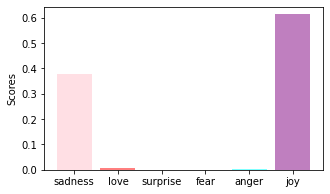

In [0]:
emotions = [label for label, _ in label_probs.items()]
scores = [score for _, score in label_probs.items()]
plt.figure(figsize=(5,3))
plt.bar(np.arange(len(emotions)), scores, align='center', alpha=0.5, color=['pink', 'red', 'orange', 'brown', 'cyan', "purple"])
plt.xticks(np.arange(len(emotions)), emotions)
plt.ylabel('Scores')
plt.show()